# Importing Libraries

In [97]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Handling

### Getting the dataset files


In [98]:
# Importing datasets tsv files

train_tsv = pd.read_csv('.\lexicons\hi.translit.sampled.train.tsv', sep = "\t").dropna()
val_tsv   = pd.read_csv('.\lexicons\hi.translit.sampled.dev.tsv'  , sep = "\t").dropna()
test_tsv  = pd.read_csv('.\lexicons\hi.translit.sampled.test.tsv' , sep = "\t").dropna()

### Generating the Vocabulary

In [99]:
# Generating the vocabulary

train_tsv.columns = ['translit', 'word',3]

hindi_chars = set()
english_chars = set()

for i,j in zip(train_tsv["translit"],train_tsv["word"]):
    hindi_chars = hindi_chars.union(set(i))
    english_chars = english_chars.union(set(j))

hindi_chars = sorted(list(hindi_chars))
english_chars = sorted(list(english_chars))

hindi_char_to_idx = {}
hindi_idx_to_char = {}

for index, char in enumerate(hindi_chars):
    hindi_char_to_idx[char] = index
    hindi_idx_to_char[index] = char

english_char_to_idx = {}
english_idx_to_char = {}

for index, char in enumerate(english_chars):
    english_char_to_idx[char] = index
    english_idx_to_char[index] = char

In [100]:
# Adding Special Characters

# '^' stands for start of sentence
# '$' stands for end of sentence
# '-' stands for padding

key_chars = ['^','$','-']

for i in key_chars:

    hindi_char_to_idx[i] = len(hindi_char_to_idx)
    hindi_idx_to_char[len(hindi_idx_to_char)] = i

    english_char_to_idx[i] = len(english_char_to_idx)
    english_idx_to_char[len(english_idx_to_char)] = i

In [101]:
def char2input(word, char_to_idx):
    '''
    word: word to be converted to input for the model
    char_to_idx: dictionary of character to index
    
    returns: Index of word with stop word included
    '''
    word = word + '$'

    return [char_to_idx[char] for char in word] # for the stop character

### Dataset and Dataloader

In [102]:
def pad_collate_fn(batch):

    x = [torch.tensor(item[0]) for item in batch]
    y = [torch.tensor(item[1]) for item in batch]

    x = torch.nn.utils.rnn.pad_sequence(x, batch_first = True, padding_value = len(english_char_to_idx)-1)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first = True, padding_value = len(hindi_char_to_idx)-1)
    
    return x,y


In [103]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, lang1_char_to_idx, lang2_idx_to_char):
        
        self.data = data

        self.lang1_char_to_idx = lang1_char_to_idx
        self.lang2_idx_to_char = lang2_idx_to_char
        
    def __len__(self):

        return len(self.data)
    
    def __getitem__(self, index):

        word = self.data.iloc[index,1]
        translit = self.data.iloc[index,0]

        return char2input(word, self.lang1_char_to_idx), char2input(translit, self.lang2_idx_to_char)

In [104]:
# Creating the dataset & dataloader

train_dataset = Dataset(train_tsv, english_char_to_idx, hindi_char_to_idx)
val_dataset   = Dataset(val_tsv  , english_char_to_idx, hindi_char_to_idx)
test_dataset  = Dataset(test_tsv , english_char_to_idx, hindi_char_to_idx)

train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=256 , shuffle=True , collate_fn = pad_collate_fn )
val_loader   = torch.utils.data.DataLoader(val_dataset   , batch_size=64  , shuffle=True , collate_fn = pad_collate_fn )
test_loader  = torch.utils.data.DataLoader(test_dataset  , batch_size=64  , shuffle=True , collate_fn = pad_collate_fn )

# Part 1

In [105]:
class seq2seq(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, layers_encoder, layers_decoder, input_vocab, output_vocab, type, dropout = 0):
        super(seq2seq, self).__init__()

        self.input_embedding_layer  = nn.Embedding(len(input_vocab), embedding_dim)
        self.output_embedding_layer = nn.Embedding(len(output_vocab), embedding_dim)

        if type == "rnn":
            self.encoder = nn.RNN(embedding_dim, hidden_dim, layers_encoder, batch_first=True, dropout = dropout)
            self.decoder = nn.RNN(embedding_dim, hidden_dim, layers_decoder, batch_first=True, dropout = dropout)

        elif type == "lstm":
            self.encoder = nn.LSTM(embedding_dim, hidden_dim, layers_encoder, batch_first=True, dropout = dropout)
            self.decoder = nn.LSTM(embedding_dim, hidden_dim, layers_decoder, batch_first=True, dropout = dropout)

        self.linear = nn.Linear(hidden_dim, len(output_vocab))

        self.output_vocab = output_vocab
        self.input_vocab  = input_vocab

        self.hidden_dim = hidden_dim

        self.layers_encoder = layers_encoder
        self.layers_decoder = layers_decoder
        
        self.type = type
        
    def forward(self, input, target = None):

        # embedding
        input = self.input_embedding_layer(input)

        # encoder
        init_hidden = torch.zeros(self.layers_encoder, input.shape[0], self.hidden_dim).to(device)
        if self.type == "rnn":

            output, hidden = self.encoder(input, init_hidden)
            # hidden = F.relu(hidden)

        elif self.type == "lstm":

            cell = torch.zeros(self.layers_encoder, input.shape[0], self.hidden_dim).to(device)

            output, (hidden, cell) = self.encoder(input, (init_hidden, cell))
            # (hidden, cell) = (F.relu(hidden), F.relu(cell))

        # decoder
        if target is not None:
            
            target = self.output_embedding_layer(target)
            target = torch.roll(target,1,1)
            target[:,0,:] = self.output_embedding_layer(torch.Tensor([[self.output_vocab['^']] for coun in range(input.shape[0])]).to(int).to(device))[:,0,:]
            
            if self.type == "rnn":
                output, hidden = self.decoder(target, hidden)
            elif self.type == "lstm":
                output, (hidden, cell) = self.decoder(target, (hidden, cell))

            output = self.linear(output)

            return output

        else:
            
            indexed_start = torch.Tensor([[self.output_vocab['^']] for coun in range(input.shape[0])]).to(int).to(device)

            output = [indexed_start]
            output_linear = []
            
            for i in range(20):
                
                if self.type == "rnn":
                    inter_output, hidden = self.decoder(self.output_embedding_layer(output[-1]), hidden)
                    output_linear.append(self.linear(inter_output))
                    output.append(torch.argmax(output_linear[-1],dim=2))

                elif self.type == "lstm":
                    inter_output, (hidden, cell) = self.decoder(self.output_embedding_layer(output[-1]), (hidden, cell))
                    output_linear.append(self.linear(inter_output))
                    output.append(torch.argmax(output_linear[-1],dim=2))

            # output = self.linear(torch.cat(output[1:], dim=1))

            return torch.cat(output_linear, dim=1)
        

# Part 2

## Utils


In [106]:
def exact_accuracy(real, pred):
    real = real
    pred = pred

    real = ["".join([hindi_idx_to_char[i] for i in j]) for j in real]
    pred = ["".join([hindi_idx_to_char[i] for i in j]) for j in pred]

    real = [i.split("$")[0] for i in real]
    pred = [i.split("$")[0] for i in pred]

    return sum([i==j for i,j in zip(real,pred)])/len(real)

In [107]:
def charlvl_accuracy(real,pred):
    real = real
    pred = pred

    real = ["".join([hindi_idx_to_char[i] for i in j]) for j in real]
    pred = ["".join([hindi_idx_to_char[i] for i in j]) for j in pred]

    real = [i.split("$")[0] for i in real]
    pred = [i.split("$")[0] for i in pred]

    real = [list(i) for i in real]
    pred = [list(i) for i in pred]

    score = 0
    count = 0

    for i,j in zip(real,pred):
        for k,l in zip(i,j):
            if k==l:
                score += 1
            count += 1

    return score/count

In [108]:
def convert_to_words(output, output_vocab):
    output = output.cpu().detach().numpy()
    output = ["".join([output_vocab[i] for i in j]) for j in output]
    output = [i.split("$")[0] for i in output]
    return output

In [109]:
def validate(
        model,
        dataloader,
        criterion,
        metrics,
        debug = 1,
):
    model.train()

    validation_loss = []

    if debug == 2:
        pbar = tqdm(dataloader)
    elif debug == 1:
        pbar = tqdm(dataloader, leave = False)
    else:
        pbar = dataloader
    

    running_loss = 0.0
    count = 1e-9

    real = []
    pred = []

    with torch.no_grad():
        for i,j in pbar:
            if debug > 0:
                pbar.set_description(f"Validation Loss {running_loss/count:.4f}")

            i = i.to(device)
            j = j.to(device)

            output = model(i)
            
            j = torch.concat((j,torch.full((j.shape[0],20 - j.shape[1]),len(hindi_char_to_idx)-1).to(int).to(device)),dim=1)
            # print("VALIDATE ::",output.shape,j.shape)
            # print("VALIDATE ::",output.reshape(-1, output.shape[-1]).shape,j.view(-1).shape)
            loss = criterion(output.reshape(-1, output.shape[-1]), j.view(-1))

            running_loss += loss.item()
            count += 1

            validation_loss.append(running_loss/count)
            
            real.extend(j.detach().cpu().tolist())
            pred.extend(torch.argmax(output, dim=2).detach().cpu().tolist())

    if debug == 0:
        print(f"Validation Loss {running_loss/count:.4f}")

    results = []

    for metric in metrics:
        results.append(metric(real, pred))

    return validation_loss , results

In [110]:
def train(
        model,
        dataloader,
        optimizer,
        criterion,
        epochs = 10,
        debug = 1,
):
    model.train()
    model.to(device)

    training_loss = []

    for EPOCH in range(epochs):

        if debug == 2:
            pbar = tqdm(dataloader)
        elif debug == 1:
            pbar = tqdm(dataloader, leave = False)
        else:
            pbar = dataloader
        

        running_loss = 0.0
        count = 1e-9

        for i,j in pbar:
            if debug > 0:
                pbar.set_description(f"Epoch {EPOCH+1} Loss {running_loss/count:.4f}")

            i = i.to(device)
            j = j.to(device)

            optimizer.zero_grad()

            output = model(i,j)

            loss = criterion(output.view(-1, output.shape[-1]), j.view(-1))

            running_loss += loss.item()
            count += 1

            loss.backward()
            optimizer.step()

        training_loss.append(running_loss/count)

        if debug == 0:
            print(f"Epoch {EPOCH+1} Loss {running_loss/count:.4f}")

    return training_loss

## Training with hyper parameters 

In [111]:
hyperparameters = []
for types in ["lstm","rnn"]:
    for input_embedding in [16,64]:
        for hidden_size in [16,64]:
            for layers in [1,3]:
                hyperparameters.append([f"{types}_{input_embedding}_{hidden_size}_{layers}",{
                    "embedding_dim" : input_embedding,
                    "hidden_dim" : hidden_size,
                    "layers_encoder" : layers,
                    "layers_decoder" : layers,
                    "input_vocab" : english_char_to_idx,
                    "output_vocab" : hindi_char_to_idx,
                    "type" : types,
                }])

len(hyperparameters)


16

In [112]:
hyper_results = {}
debug = 1
for name,parameters in hyperparameters:
    print(name)

    model = seq2seq(**parameters)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=len(hindi_char_to_idx)-1)

    training_loss = train(model, train_loader, optimizer, criterion, epochs = 10, debug = debug)
    validation_loss, results = validate(model, val_loader, criterion, [exact_accuracy, charlvl_accuracy], debug = debug)

    print(f"\tExact accuracy : \t{results[0]*100:.2f}\n\tChar level accuracy : \t{results[1]*100:.2f}")
    print()

    hyper_results[name] = {
        "training_loss" : training_loss,
        "validation_loss" : validation_loss,
        "exact_accuracy" : results[0],
        "char_accuracy" : results[1],
    }

lstm_16_16_1


	Exact accuracy : 	0.62
	Char level accuracy : 	23.66

lstm_16_16_3


	Exact accuracy : 	0.76
	Char level accuracy : 	28.69

lstm_16_64_1


	Exact accuracy : 	15.26
	Char level accuracy : 	51.99

lstm_16_64_3


	Exact accuracy : 	26.92
	Char level accuracy : 	64.47

lstm_64_16_1


	Exact accuracy : 	1.01
	Char level accuracy : 	27.35

lstm_64_16_3


	Exact accuracy : 	1.29
	Char level accuracy : 	30.98

lstm_64_64_1


	Exact accuracy : 	17.83
	Char level accuracy : 	53.51

lstm_64_64_3


	Exact accuracy : 	19.83
	Char level accuracy : 	57.66

rnn_16_16_1


	Exact accuracy : 	0.00
	Char level accuracy : 	8.99

rnn_16_16_3


	Exact accuracy : 	0.00
	Char level accuracy : 	8.83

rnn_16_64_1


	Exact accuracy : 	0.00
	Char level accuracy : 	7.04

rnn_16_64_3


	Exact accuracy : 	0.00
	Char level accuracy : 	7.48

rnn_64_16_1


	Exact accuracy : 	0.00
	Char level accuracy : 	8.92

rnn_64_16_3


	Exact accuracy : 	0.00
	Char level accuracy : 	8.55

rnn_64_64_1


	Exact accuracy : 	0.00
	Char level accuracy : 	7.21

rnn_64_64_3


	Exact accuracy : 	0.00
	Char level accuracy : 	6.94



In [113]:
for i in hyper_results:
    print(f"{i} : {hyper_results[i]['exact_accuracy']*100:.2f}")

lstm_16_16_1 : 0.62
lstm_16_16_3 : 0.76
lstm_16_64_1 : 15.26
lstm_16_64_3 : 26.92
lstm_64_16_1 : 1.01
lstm_64_16_3 : 1.29
lstm_64_64_1 : 17.83
lstm_64_64_3 : 19.83
rnn_16_16_1 : 0.00
rnn_16_16_3 : 0.00
rnn_16_64_1 : 0.00
rnn_16_64_3 : 0.00
rnn_64_16_1 : 0.00
rnn_64_16_3 : 0.00
rnn_64_64_1 : 0.00
rnn_64_64_3 : 0.00


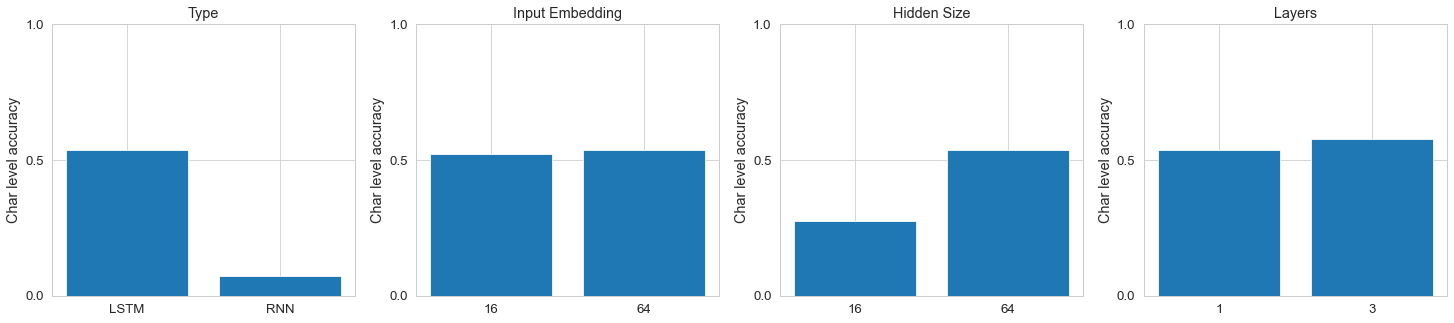

In [120]:
# make 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(25,5))

# plot the data
axs[0].bar([0,1],[hyper_results[f"{i}_64_64_1"]["char_accuracy"] for i in ["lstm","rnn"]])
axs[1].bar([0,1],[hyper_results[f"lstm_{i}_64_1"]["char_accuracy"] for i in [16,64]])
axs[2].bar([0,1],[hyper_results[f"lstm_64_{i}_1"]["char_accuracy"] for i in [16,64]])
axs[3].bar([0,1],[hyper_results[f"lstm_64_64_{i}"]["char_accuracy"] for i in [1,3]])

# set titles
axs[0].set_title("Type")
axs[1].set_title("Input Embedding")
axs[2].set_title("Hidden Size")
axs[3].set_title("Layers")

# set xticks
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(["LSTM","RNN"])
axs[1].set_xticks([0,1])
axs[1].set_xticklabels([16,64])
axs[2].set_xticks([0,1])
axs[2].set_xticklabels([16,64])
axs[3].set_xticks([0,1])
axs[3].set_xticklabels([1,3])

# set yticks
axs[0].set_yticks([0,0.5,1])
axs[1].set_yticks([0,0.5,1])
axs[2].set_yticks([0,0.5,1])
axs[3].set_yticks([0,0.5,1])

# set ylabels
axs[0].set_ylabel("Char level accuracy")
axs[1].set_ylabel("Char level accuracy")
axs[2].set_ylabel("Char level accuracy")
axs[3].set_ylabel("Char level accuracy")

plt.show()



## Part 3

In [121]:
model = seq2seq(64, 64, 1, 1, english_char_to_idx, hindi_char_to_idx, "lstm")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=len(hindi_char_to_idx)-1)

training_loss = train(model, train_loader, optimizer, criterion, epochs = 10, debug = debug)
validation_loss, results = validate(model, val_loader, criterion, [exact_accuracy, charlvl_accuracy], debug = debug)

In [122]:
test_loss, test_metrics = validate(model, test_loader, criterion, [exact_accuracy,charlvl_accuracy], debug=-1)
print(test_metrics)

[0.163741390802044, 0.5221500295333728]


In [123]:
model = seq2seq(64, 64, 1, 1, english_char_to_idx, hindi_char_to_idx, "lstm",dropout=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=len(hindi_char_to_idx)-1)

training_loss = train(model, train_loader, optimizer, criterion, epochs = 10, debug = debug)
validation_loss, results = validate(model, val_loader, criterion, [exact_accuracy, charlvl_accuracy], debug = debug)

c:\Users\rohit\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [124]:
test_loss, test_metrics = validate(model, test_loader, criterion, [exact_accuracy,charlvl_accuracy], debug=-1)
print(test_metrics)

[0.16463008220395467, 0.5278804499026271]


## Part 4

## LSTM

In [125]:
lstm_modular = seq2seq(64, 64, 1, 1, english_char_to_idx, hindi_char_to_idx, "lstm")
lstm_modular = lstm_modular.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_modular.parameters(), lr=0.01)

lstm_losses = train(lstm_modular, train_loader, optimizer, criterion, epochs=10, debug=2)
lstm_val_loss, lstm_val_metrics = validate(lstm_modular, val_loader, criterion, [exact_accuracy,charlvl_accuracy], debug=0)

print(lstm_val_metrics)

Epoch 10 Loss 0.3474: 100%|██████████| 173/173 [00:08<00:00, 20.73it/s]


Validation Loss 1.3566
[0.16502180399357355, 0.5289920078290654]


In [128]:
lstm_test_loss, lstm_test_metrics = validate(lstm_modular, test_loader, criterion, [exact_accuracy,charlvl_accuracy], debug=-1)

print(lstm_val_metrics)

[0.16502180399357355, 0.5289920078290654]


## ATTENTION LSTM

In [126]:
class Attention_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, layers_encoder, layers_decoder, input_vocab, output_vocab, max_length = 20):
        super(Attention_LSTM, self).__init__()

        self.input_embedding_layer  = nn.Embedding(len(input_vocab), embedding_dim)
        self.output_embedding_layer = nn.Embedding(len(output_vocab), embedding_dim)

        self.encoder = nn.LSTM(embedding_dim, hidden_dim, layers_encoder, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, layers_decoder, batch_first=True)

        self.attention_score = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.linear = nn.Linear(hidden_dim, len(output_vocab))

        self.output_vocab = output_vocab
        self.input_vocab  = input_vocab

        self.hidden_dim = hidden_dim

        self.layers_encoder = layers_encoder
        self.layers_decoder = layers_decoder

        self.max_length = max_length
        
    def forward(self, input, target = None):

        input = self.input_embedding_layer(input)

        hidden = torch.ones(self.layers_encoder, input.shape[0], self.hidden_dim).to(device)
        cell   = torch.ones(self.layers_encoder, input.shape[0], self.hidden_dim).to(device)

        # print("meow")

        Encoder_hidden_state = []
        for i in range(input.shape[1]):

            output , (hidden, cell) = self.encoder(input[:,i,:].unsqueeze(1), (hidden, cell))
            Encoder_hidden_state.append(output)

        Encoder_hidden_state = torch.cat(Encoder_hidden_state, dim=1)

        if target is not None:
            
            target = self.output_embedding_layer(target)
            target = torch.roll(target,1,1)
            target[:,0,:] = self.output_embedding_layer(torch.Tensor([[self.output_vocab['^']] for coun in range(input.shape[0])]).to(int).to(device))[:,0,:]
            
            output_list = []
            for i in range(target.shape[1]):

                dhidden = hidden[-1].unsqueeze(1).repeat(1,Encoder_hidden_state.shape[1],1)
                attention_scores = F.softmax(self.attention_score(torch.cat((dhidden,Encoder_hidden_state),dim=2)),dim=1)
                context_vector = torch.sum(attention_scores*Encoder_hidden_state, dim=1)

                output, (hidden, cell) = self.decoder(torch.concat((target[:,i,:],context_vector),dim=1).unsqueeze(1), (hidden, cell))
                output_list.append(output)

            output_list = torch.cat(output_list, dim=1)
            output = self.linear(output_list)

            return output

        else:
            
            indexed_start = torch.Tensor([[self.output_vocab['^']] for coun in range(input.shape[0])]).to(int).to(device)

            output = [indexed_start]
            output_linear = []

            for i in range(self.max_length):

                dhidden = hidden[-1].unsqueeze(1).repeat(1,Encoder_hidden_state.shape[1],1)
                attention_scores = F.softmax(self.attention_score(torch.cat((dhidden,Encoder_hidden_state),dim=2)),dim=1)
                context_vector = torch.sum(attention_scores*Encoder_hidden_state, dim=1)
                
                inter_output, (hidden, cell) = self.decoder(torch.concat((self.output_embedding_layer(output[-1])[:,0,:],context_vector),dim=1).unsqueeze(1), (hidden, cell))
                
                output_linear.append(self.linear(inter_output))
                output.append(torch.argmax(output_linear[-1],dim=2))

            return torch.cat(output_linear, dim=1)
        

In [127]:
att_modular = Attention_LSTM(64, 64, 1, 1, english_char_to_idx, hindi_char_to_idx)

att_modular = att_modular.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(att_modular.parameters(), lr=0.01)

att_losses = train(att_modular, train_loader, optimizer, criterion, epochs=10, debug=2)
att_val_loss, att_val_metrics = validate(att_modular, val_loader, criterion, [exact_accuracy,charlvl_accuracy], debug=0)

print(att_val_metrics)

Epoch 10 Loss 0.1810: 100%|██████████| 173/173 [00:17<00:00,  9.73it/s]


Validation Loss 0.9757
[0.34404406701859075, 0.7001525124418044]


In [129]:
att_test_loss, att_test_metrics = validate(att_modular, test_loader, criterion, [exact_accuracy,charlvl_accuracy], debug=-1)

print(att_val_metrics)

[0.34404406701859075, 0.7001525124418044]


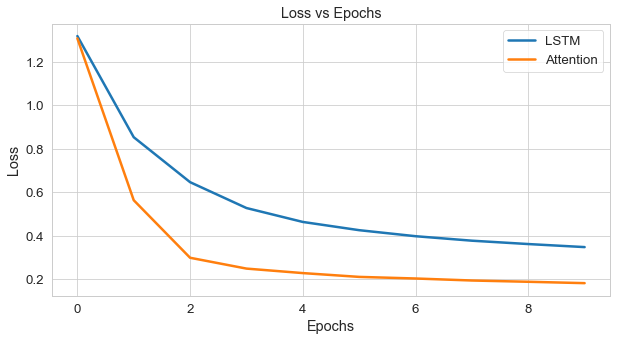

In [130]:
plt.figure(figsize=(10,5))
plt.plot(lstm_losses, label="LSTM")
plt.plot(att_losses, label="Attention")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

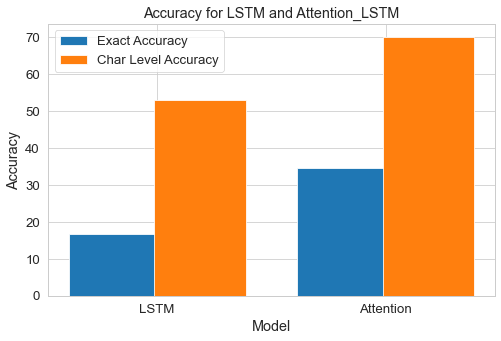

In [131]:
plt.figure(figsize=(8,5))
plt.bar([0,2], [lstm_val_metrics[0]*100, att_val_metrics[0]*100], label="Exact Accuracy")
plt.bar([0.75,2.75], [lstm_val_metrics[1]*100, att_val_metrics[1]*100], label="Char Level Accuracy")
plt.xticks([0.375,2.375], ["LSTM", "Attention"])
plt.legend()
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy for LSTM and Attention_LSTM")
plt.show()


# Question 2

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Preprocessing

In [133]:
dataset2 = pd.read_csv("./household_power_consumption/household_power_consumption.txt",sep=";",header=0,parse_dates=True,infer_datetime_format=True)
dataset2["Global_active_power"].replace("?", np.nan, inplace = True)
dataset2.dropna(subset=["Global_active_power"], inplace=True)
dataset2['datetime'] = pd.to_datetime(dataset2['Date'] + ' ' + dataset2['Time'])
dataset2 = dataset2.set_index('datetime')
dataset2 = dataset2.resample('D').mean()
# dataset2 = dataset2.astype({"Global_active_power": float})


c:\Users\rohit\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [134]:
dataset2 = dataset2[["Sub_metering_3"]].dropna()
dataset2 = dataset2.values

[]

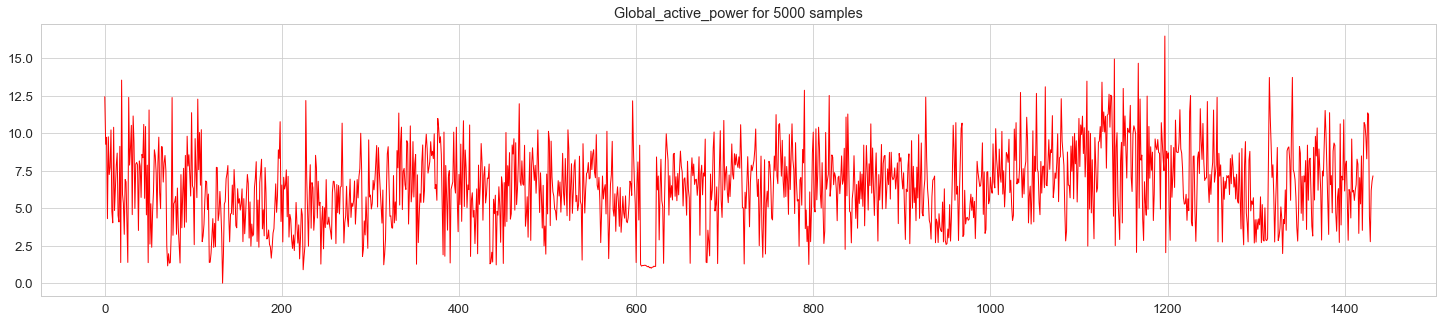

In [135]:
data = list(map(float,dataset2))[:5000]

plt.figure(figsize=(25,5))
plt.plot(data, color='red', label='Global_active_power', linewidth=1)
plt.title('Global_active_power for 5000 samples')
plt.plot()

In [136]:
scaler = MinMaxScaler()
dataset2_scaled = pd.DataFrame(scaler.fit_transform(dataset2))

## model

In [137]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _  = self.lstm(x, (h0, c0))
        out     = self.fc(out[:, -1, :])

        return out

## 80:20 Split

In [138]:
train_size = int(len(dataset2_scaled) * 0.8)
train, test = dataset2_scaled[:train_size], dataset2_scaled[train_size:]

In [140]:
# Define hyperparameters
input_dim = train.shape[1]
hidden_dim = 64
output_dim = 1

num_layers = 1
lr = 0.001
num_epochs = 50

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_steps = 30

training_losses = []
test_loss = 0
for epoch in range(num_epochs):

    running_losss = 0.0
    count = 1e-9

    for i in tqdm(range(n_steps, len(train))):

        x = train.iloc[i-n_steps:i].values
        y = train.iloc[i].values

        # print(x.shape, y.shape)
        
        x_tensor = torch.tensor(x, dtype=torch.float).unsqueeze(0).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float).unsqueeze(0).to(device)
        
        output = model(x_tensor)
        loss = criterion(output, y_tensor)

        running_losss += loss.item()
        count += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_losses.append(running_losss/count)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

with torch.no_grad():

    count = 1e-9

    results = []
    
    for i in tqdm(range(n_steps, len(test))):

        x = test.iloc[i-n_steps:i].values
        y = test.iloc[i].values

        # print(x.shape, y.shape)
        
        x_tensor = torch.tensor(x, dtype=torch.float).unsqueeze(0).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float).unsqueeze(0).to(device)
        
        output = model(x_tensor)
        loss = criterion(output, y_tensor)

        test_loss += loss.item()
        count += 1

        results.append(output.cpu().numpy()[0])

    test_predicted = scaler.inverse_transform(results)

print('Test Loss: {:.4f}'.format(test_loss/count))
print("training_losses", training_losses[-1])

plt.figure(figsize=(10,5))
plt.plot(training_losses, label="Training Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()


100%|██████████| 1116/1116 [00:06<00:00, 180.98it/s]


Epoch [1/50], Loss: 0.1052


  4%|▍         | 47/1116 [00:00<00:06, 153.19it/s]

## 70:30 Split

In [ ]:
train_size = int(len(dataset2_scaled) * 0.7)
train, test = dataset2_scaled[:train_size], dataset2_scaled[train_size:]

100%|██████████| 973/973 [00:05<00:00, 189.63it/s]


Epoch [1/50], Loss: 0.0237


100%|██████████| 973/973 [00:04<00:00, 205.95it/s]


Epoch [2/50], Loss: 0.0201


100%|██████████| 973/973 [00:03<00:00, 282.12it/s]


Epoch [3/50], Loss: 0.0198


100%|██████████| 973/973 [00:03<00:00, 259.93it/s]


Epoch [4/50], Loss: 0.0196


100%|██████████| 973/973 [00:04<00:00, 199.95it/s]


Epoch [5/50], Loss: 0.0195


100%|██████████| 973/973 [00:05<00:00, 182.92it/s]


Epoch [6/50], Loss: 0.0194


100%|██████████| 973/973 [00:04<00:00, 216.56it/s]


Epoch [7/50], Loss: 0.0193


100%|██████████| 973/973 [00:06<00:00, 141.33it/s]


Epoch [8/50], Loss: 0.0192


100%|██████████| 973/973 [00:04<00:00, 198.79it/s]


Epoch [9/50], Loss: 0.0191


100%|██████████| 973/973 [00:03<00:00, 248.85it/s]


Epoch [10/50], Loss: 0.0190


100%|██████████| 973/973 [00:03<00:00, 249.22it/s]


Epoch [11/50], Loss: 0.0189


100%|██████████| 973/973 [00:04<00:00, 205.71it/s]


Epoch [12/50], Loss: 0.0189


100%|██████████| 973/973 [00:03<00:00, 250.12it/s]


Epoch [13/50], Loss: 0.0188


100%|██████████| 973/973 [00:03<00:00, 265.84it/s]


Epoch [14/50], Loss: 0.0188


100%|██████████| 973/973 [00:03<00:00, 264.22it/s]


Epoch [15/50], Loss: 0.0186


100%|██████████| 973/973 [00:07<00:00, 130.48it/s]


Epoch [16/50], Loss: 0.0187


100%|██████████| 973/973 [00:06<00:00, 140.98it/s]


Epoch [17/50], Loss: 0.0186


100%|██████████| 973/973 [00:05<00:00, 168.45it/s]


Epoch [18/50], Loss: 0.0186


100%|██████████| 973/973 [00:05<00:00, 191.58it/s]


Epoch [19/50], Loss: 0.0185


100%|██████████| 973/973 [00:06<00:00, 155.37it/s]


Epoch [20/50], Loss: 0.0184


100%|██████████| 973/973 [00:04<00:00, 198.66it/s]


Epoch [21/50], Loss: 0.0185


100%|██████████| 973/973 [00:04<00:00, 242.88it/s]


Epoch [22/50], Loss: 0.0184


100%|██████████| 973/973 [00:03<00:00, 245.19it/s]


Epoch [23/50], Loss: 0.0183


100%|██████████| 973/973 [00:03<00:00, 262.85it/s]


Epoch [24/50], Loss: 0.0184


100%|██████████| 973/973 [00:04<00:00, 239.08it/s]


Epoch [25/50], Loss: 0.0183


100%|██████████| 973/973 [00:03<00:00, 267.72it/s]


Epoch [26/50], Loss: 0.0183


100%|██████████| 973/973 [00:03<00:00, 249.95it/s]


Epoch [27/50], Loss: 0.0183


100%|██████████| 973/973 [00:04<00:00, 236.55it/s]


Epoch [28/50], Loss: 0.0182


100%|██████████| 973/973 [00:03<00:00, 259.79it/s]


Epoch [29/50], Loss: 0.0182


100%|██████████| 973/973 [00:03<00:00, 245.36it/s]


Epoch [30/50], Loss: 0.0182


100%|██████████| 973/973 [00:03<00:00, 259.41it/s]


Epoch [31/50], Loss: 0.0182


100%|██████████| 973/973 [00:03<00:00, 266.77it/s]


Epoch [32/50], Loss: 0.0182


100%|██████████| 973/973 [00:04<00:00, 234.44it/s]


Epoch [33/50], Loss: 0.0181


100%|██████████| 973/973 [00:03<00:00, 253.26it/s]


Epoch [34/50], Loss: 0.0181


100%|██████████| 973/973 [00:03<00:00, 260.32it/s]


Epoch [35/50], Loss: 0.0181


100%|██████████| 973/973 [00:04<00:00, 239.25it/s]


Epoch [36/50], Loss: 0.0180


100%|██████████| 973/973 [00:04<00:00, 234.15it/s]


Epoch [37/50], Loss: 0.0179


100%|██████████| 973/973 [00:04<00:00, 210.37it/s]


Epoch [38/50], Loss: 0.0180


100%|██████████| 973/973 [00:03<00:00, 274.87it/s]


Epoch [39/50], Loss: 0.0181


100%|██████████| 973/973 [00:03<00:00, 268.04it/s]


Epoch [40/50], Loss: 0.0180


100%|██████████| 973/973 [00:03<00:00, 258.59it/s]


Epoch [41/50], Loss: 0.0181


100%|██████████| 973/973 [00:03<00:00, 276.86it/s]


Epoch [42/50], Loss: 0.0179


100%|██████████| 973/973 [00:03<00:00, 253.17it/s]


Epoch [43/50], Loss: 0.0178


100%|██████████| 973/973 [00:04<00:00, 240.92it/s]


Epoch [44/50], Loss: 0.0177


100%|██████████| 973/973 [00:03<00:00, 245.73it/s]


Epoch [45/50], Loss: 0.0180


100%|██████████| 973/973 [00:04<00:00, 227.78it/s]


Epoch [46/50], Loss: 0.0178


100%|██████████| 973/973 [00:04<00:00, 241.33it/s]


Epoch [47/50], Loss: 0.0177


100%|██████████| 973/973 [00:04<00:00, 235.12it/s]


Epoch [48/50], Loss: 0.0177


100%|██████████| 973/973 [00:04<00:00, 214.96it/s]


Epoch [49/50], Loss: 0.0176


100%|██████████| 973/973 [00:03<00:00, 275.52it/s]


Epoch [50/50], Loss: 0.0176


100%|██████████| 400/400 [00:00<00:00, 664.50it/s]


Test Loss: 0.0307
training_losses 0.0176311587781969


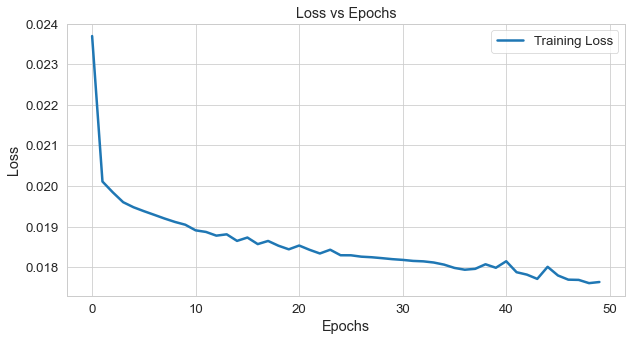

In [ ]:
# Define hyperparameters
input_dim = train.shape[1]
hidden_dim = 64
output_dim = 1

num_layers = 1
lr = 0.001
num_epochs = 50

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_steps = 30

training_losses = []
test_loss = 0
for epoch in range(num_epochs):

    running_losss = 0.0
    count = 1e-9

    for i in tqdm(range(n_steps, len(train))):

        x = train.iloc[i-n_steps:i].values
        y = train.iloc[i].values

        # print(x.shape, y.shape)
        
        x_tensor = torch.tensor(x, dtype=torch.float).unsqueeze(0).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float).unsqueeze(0).to(device)
        
        output = model(x_tensor)
        loss = criterion(output, y_tensor)

        running_losss += loss.item()
        count += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_losses.append(running_losss/count)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_losss/count))

with torch.no_grad():

    count = 1e-9

    results = []
    
    for i in tqdm(range(n_steps, len(test))):

        x = test.iloc[i-n_steps:i].values
        y = test.iloc[i].values

        # print(x.shape, y.shape)
        
        x_tensor = torch.tensor(x, dtype=torch.float).unsqueeze(0).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float).unsqueeze(0).to(device)
        
        output = model(x_tensor)
        loss = criterion(output, y_tensor)

        test_loss += loss.item()
        count += 1

        results.append(output.cpu().numpy()[0])

    test_predicted = scaler.inverse_transform(results)

print('Test Loss: {:.4f}'.format(test_loss/count))
print("training_losses", training_losses[-1])

plt.figure(figsize=(10,5))
plt.plot(training_losses, label="Training Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()
